In [387]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

# Auto reload of library
%reload_ext autoreload
%autoreload 2

from import_KK import *
DeviceStrategy_CPU()
from preprocessing_KK import *
from description_KK import *
from algorithm_KK import *
from evaluation_KK import *

# Hyperparameters

In [ ]:
# hyperparameters
test_criteria = '2023-01-01'
SEQUENCE = 5
Y_SCALING = True
MOVING_TYPE = 'sliding'    # 'sliding', 'expanding'
TRAIN_WINDOW = 100
FORECASTING_PERIOD = 26
################
# metrics.SCORERS.keys(): 'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'
LOSS_ML = 'neg_mean_squared_error' 
PARAMS_BAG = None
# PARAMS_BAG = {'n_estimators': [30, 50, 90],     
#           'max_depth': [20, 30, 40, 50],  
#           'max_leaf_nodes': [5, 10, 15]}
PARAMS_BOOST = None
# PARAMS_BOOST = {'n_estimators': [30, 50, 90],    
#           'max_depth': [20, 30, 40, 50],   
#           'num_leaves': [5, 10, 15],
#           'min_child_weight': [3, 5, 7],
#           'learning_rate': [0.1, 0.01],
#           'force_col_wise': [False], 'force_row_wise': [True]}
CV_SPLITS = 5
################
KERNEL_SIZE = 2
STRIDE = 1
POOL_SIZE = 1
POOL_STRIDE = 1
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = None
DROPOUT_RATIO = 0.2
MODEL_SUMMARY = False
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
VALIDATION_SPLIT = 0.2
VALIDATION_DATA = None
BATCH_SIZE = 32
EPOCHS = 200
VERBOSE = 0
################
EARLYSTOP_PATIENT = 100
MONITOR = 'val_loss'
LEARNING_PLOT = False
PLOT_TITLE = "How People's Interest Changes Over Time"
PLOT_XLABEL = 'Time'
PLOT_YLABEL = 'Interest Forecasting'
################

# 데이터로딩
file_location = os.path.join(os.getcwd(), 'Data', 'ageism_survey_KK.xlsx')
df = pd.read_excel(file_location, sheet_name='GT_Trend', index_col='Time')
df_global = df[['Ageism']].copy()
df_local = df[['고령화']].copy()

# Modeling

## ML

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [06:30<00:00,  7.96s/it]


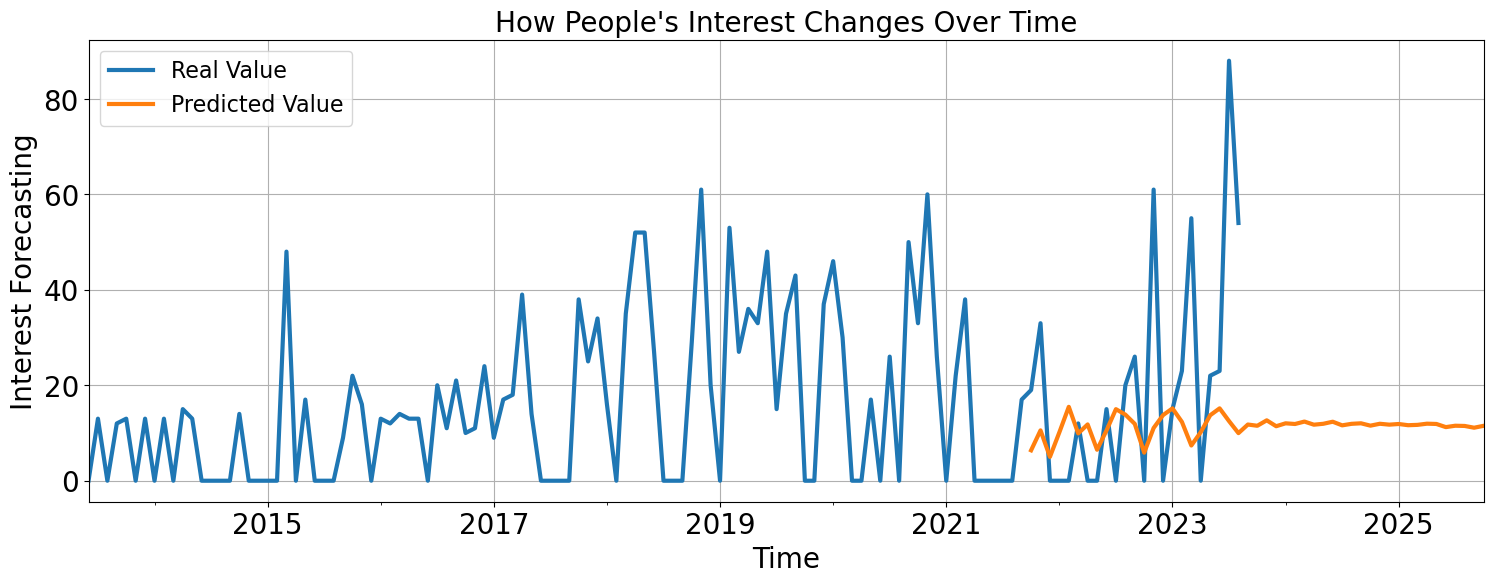

,MAE,MSE,MAPE
Score,17.3763,637.9121,"18,350,713,218,196,664.0000"


In [393]:
model, Score_te = modeling_RandomForestRegressor_slidingwindow1D(df_global, SEQUENCE=SEQUENCE, Y_SCALING=Y_SCALING, MOVING_TYPE=MOVING_TYPE,
                                               TRAIN_WINDOW=TRAIN_WINDOW, FORECASTING_PERIOD=FORECASTING_PERIOD,
                                               LOSS=LOSS_ML, GRIDSEARCH_PARAMS=PARAMS_BAG, CV_SPLITS=CV_SPLITS,
                                               PLOT_TITLE=PLOT_TITLE, PLOT_XLABEL=PLOT_XLABEL, PLOT_YLABEL=PLOT_YLABEL)
Score_te

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.51it/s]


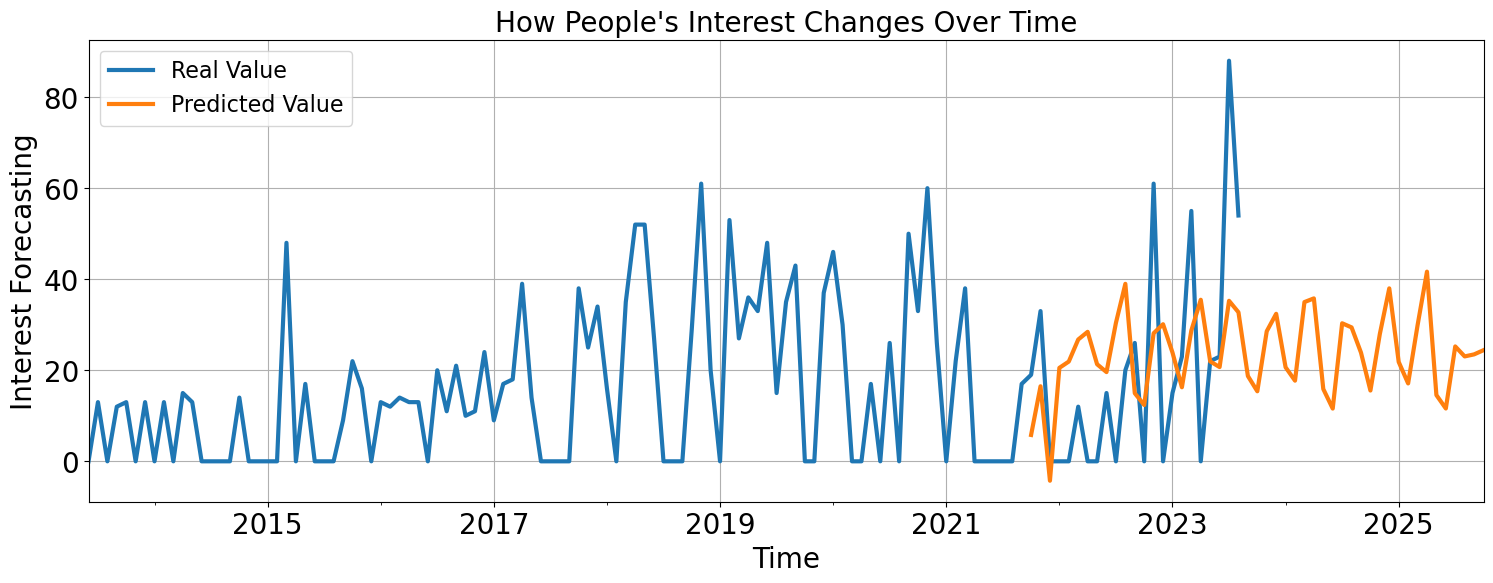

,MAE,MSE,MAPE
Score,18.9174,510.0449,"40,116,589,089,021,688.0000"


In [391]:
model, Score_te = modeling_LGBMRegressor_slidingwindow1D(df_global, SEQUENCE=SEQUENCE, Y_SCALING=Y_SCALING, MOVING_TYPE=MOVING_TYPE,
                                               TRAIN_WINDOW=TRAIN_WINDOW, FORECASTING_PERIOD=FORECASTING_PERIOD,
                                               LOSS=LOSS_ML, GRIDSEARCH_PARAMS=PARAMS_BOOST, CV_SPLITS=CV_SPLITS,
                                               PLOT_TITLE=PLOT_TITLE, PLOT_XLABEL=PLOT_XLABEL, PLOT_YLABEL=PLOT_YLABEL)
Score_te

In [ ]:
# 예측값 말고 실제값 반영 시나리오 테스트

## MLP

In [ ]:
# 전처리
X, Y = reshape_1Dto2Dseq(df_global, SEQUENCE)
X_train, Y_train = X.loc[X.index < test_criteria,:], Y.loc[Y.index < test_criteria,:]
X_test, Y_test = X.loc[X.index >= test_criteria,:], Y.loc[Y.index >= test_criteria,:]
X_train, X_test = feature_num_scaling_trte(preprocessing.MinMaxScaler(), X_train, X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
model = modeling_MLP(X_train, Y_train, 
                     HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                     REGULARIZER=REGULARIZER, DROPOUT_RATIO=DROPOUT_RATIO,
                     LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS)
model, save_name = learning(model, X_train, X_test, Y_train,
                            VALIDATION_SPLIT=VALIDATION_SPLIT, VALIDATION_DATA=VALIDATION_DATA,
                            BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                            MONITOR=MONITOR, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                            HISTORY_METRICS=METRICS)
Score_te, Score_trte = prediction_reg(model, X_train, Y_train, X_test, Y_test, ALGO_NAME='MLP')
display(Score_te, Score_trte)

## MLP with moving window

In [338]:
# hyperparameters
test_criteria = '2023-01-01'
SEQUENCE = 5
Y_SCALING = True
MOVING_TYPE = 'sliding'    # 'sliding', 'expanding'
TRAIN_WINDOW = 100
FORECASTING_PERIOD = 26
KERNEL_SIZE = 2
STRIDE = 1
POOL_SIZE = 1
POOL_STRIDE = 1
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = None
DROPOUT_RATIO = 0.2
MODEL_SUMMARY = False
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
VALIDATION_SPLIT = 0.2
VALIDATION_DATA = None
BATCH_SIZE = 32
EPOCHS = 200
VERBOSE = 0
################
EARLYSTOP_PATIENT = 100
MONITOR = 'val_loss'
LEARNING_PLOT = False
PLOT_TITLE = "How People's Interest Changes Over Time"
PLOT_XLABEL = 'Time'
PLOT_YLABEL = 'Interest Forecasting'
################

# 데이터로딩
file_location = os.path.join(os.getcwd(), 'Data', 'ageism_survey_KK.xlsx')
df = pd.read_excel(file_location, sheet_name='GT_Trend', index_col='Time')
df_global = df[['Ageism']].copy()
df_local = df[['고령화']].copy()

  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


  2%|█▋                                                                                 | 1/49 [00:04<03:50,  4.80s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 42ms/step


  4%|███▍                                                                               | 2/49 [00:09<03:31,  4.49s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


  6%|█████                                                                              | 3/49 [00:13<03:26,  4.49s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


  8%|██████▊                                                                            | 4/49 [00:17<03:16,  4.36s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 10%|████████▍                                                                          | 5/49 [00:21<03:01,  4.13s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 12%|██████████▏                                                                        | 6/49 [00:25<02:57,  4.12s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 14%|███████████▊                                                                       | 7/49 [00:29<02:55,  4.19s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▌                                                                     | 8/49 [00:35<03:15,  4.76s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 18%|███████████████▏                                                                   | 9/49 [00:39<02:58,  4.46s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▋                                                                 | 10/49 [00:45<03:12,  4.95s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 22%|██████████████████▍                                                               | 11/49 [00:51<03:18,  5.22s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 24%|████████████████████                                                              | 12/49 [00:57<03:17,  5.34s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▊                                                            | 13/49 [01:02<03:17,  5.49s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 29%|███████████████████████▍                                                          | 14/49 [01:08<03:15,  5.59s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████                                                         | 15/49 [01:12<02:53,  5.09s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▊                                                       | 16/49 [01:17<02:48,  5.12s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████▍                                                     | 17/49 [01:22<02:35,  4.85s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 37%|██████████████████████████████                                                    | 18/49 [01:27<02:31,  4.88s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▊                                                  | 19/49 [01:31<02:20,  4.69s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▍                                                | 20/49 [01:36<02:23,  4.95s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 43%|███████████████████████████████████▏                                              | 21/49 [01:41<02:11,  4.71s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 45%|████████████████████████████████████▊                                             | 22/49 [01:46<02:13,  4.95s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 47%|██████████████████████████████████████▍                                           | 23/49 [01:50<01:57,  4.54s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 39ms/step


 49%|████████████████████████████████████████▏                                         | 24/49 [01:54<01:51,  4.45s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 51%|█████████████████████████████████████████▊                                        | 25/49 [01:58<01:42,  4.29s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████▌                                      | 26/49 [02:02<01:34,  4.12s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 55%|█████████████████████████████████████████████▏                                    | 27/49 [02:05<01:23,  3.79s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 35ms/step


 57%|██████████████████████████████████████████████▊                                   | 28/49 [02:08<01:14,  3.55s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▌                                 | 29/49 [02:11<01:07,  3.39s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████████▏                               | 30/49 [02:14<01:02,  3.27s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 63%|███████████████████████████████████████████████████▉                              | 31/49 [02:17<00:58,  3.22s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [02:20<00:54,  3.22s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [02:23<00:50,  3.16s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [02:26<00:46,  3.08s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [02:29<00:45,  3.27s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [02:33<00:42,  3.27s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [02:36<00:38,  3.21s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [02:41<00:41,  3.73s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [02:44<00:35,  3.54s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [02:48<00:33,  3.73s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 35ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [02:51<00:27,  3.45s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [02:56<00:26,  3.82s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [02:58<00:21,  3.52s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 34ms/step


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [03:01<00:16,  3.31s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [03:04<00:12,  3.14s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [03:08<00:09,  3.29s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [03:11<00:06,  3.21s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 35ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [03:13<00:03,  3.11s/it]

Training:   0%|                                                                               0/200 ETA: ?s,  …

1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [03:16<00:00,  4.02s/it]


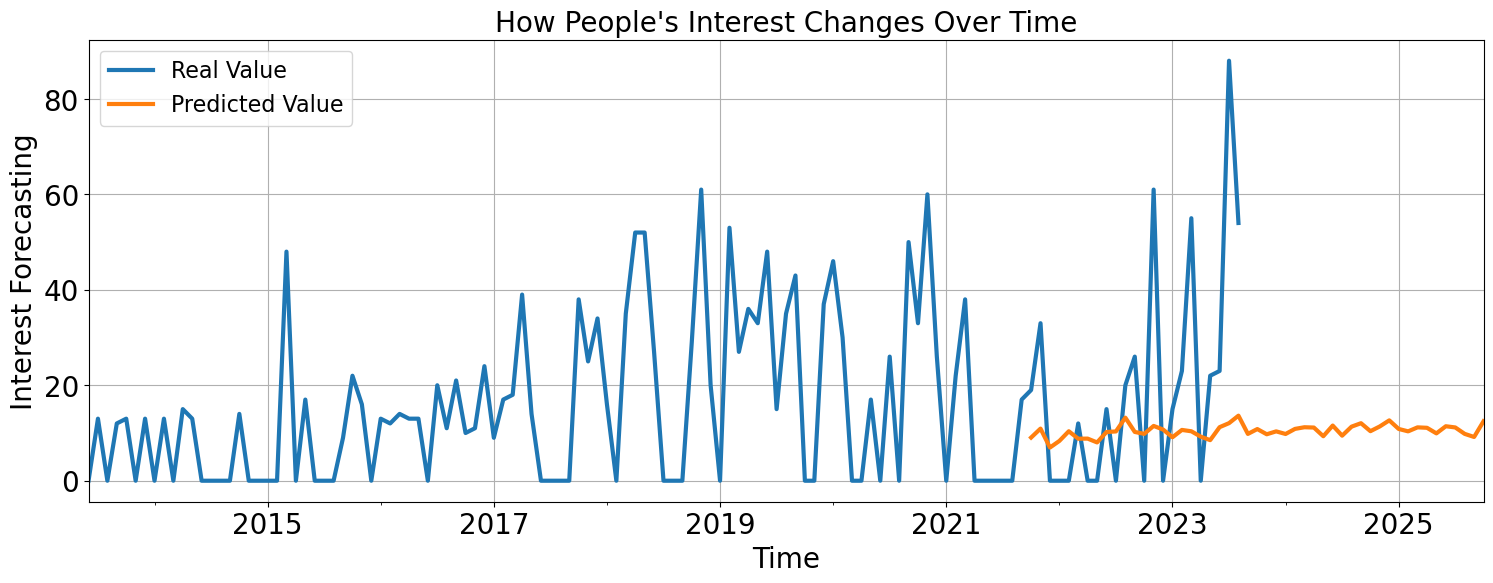

,MAE,MSE,MAPE
Score,17.3562,610.2260,"16,173,197,569,294,336.0000"


In [346]:
model, Score_te = modeling_MLP_slidingwindow1D(df_global, SEQUENCE=SEQUENCE, Y_SCALING=Y_SCALING, MOVING_TYPE=MOVING_TYPE,
                                               TRAIN_WINDOW=TRAIN_WINDOW, FORECASTING_PERIOD=FORECASTING_PERIOD,
                                               HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                                               REGULARIZER=REGULARIZER, DROPOUT_RATIO=DROPOUT_RATIO, MODEL_SUMMARY=MODEL_SUMMARY,
                                               LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS,
                                               VALIDATION_SPLIT=VALIDATION_SPLIT, VALIDATION_DATA=VALIDATION_DATA,
                                               BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                                               MONITOR=MONITOR, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                                               LEARNING_PLOT=LEARNING_PLOT,
                                               PLOT_TITLE=PLOT_TITLE, PLOT_XLABEL=PLOT_XLABEL, PLOT_YLABEL=PLOT_YLABEL)
Score_te

In [349]:
# hyperparameters
test_criteria = '2023-01-01'
SEQUENCE = 5
Y_SCALING = True
MOVING_TYPE = 'sliding'   # 'sliding', 'expanding'
TRAIN_WINDOW = 100
FORECASTING_PERIOD = 26
KERNEL_SIZE = 2
STRIDE = 1
POOL_SIZE = 1
POOL_STRIDE = 1
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = None
DROPOUT_RATIO = 0.2
MODEL_SUMMARY = False
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
VALIDATION_SPLIT = 0.2
VALIDATION_DATA = None
BATCH_SIZE = 32
EPOCHS = 500
VERBOSE = 0
################
EARLYSTOP_PATIENT = EPOCHS*0.4
MONITOR = 'val_loss'
LEARNING_PLOT = False
PLOT_TITLE = "How People's Interest Changes Over Time"
PLOT_XLABEL = 'Time'
PLOT_YLABEL = 'Interest Forecasting'
################

# 데이터로딩
file_location = os.path.join(os.getcwd(), 'Data', 'ageism_survey_KK.xlsx')
df = pd.read_excel(file_location, sheet_name='GT_Trend', index_col='Time')
df_global = df[['Ageism']].copy()
df_local = df[['고령화']].copy()

  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


  2%|█▋                                                                                 | 1/49 [00:06<05:35,  6.98s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


  4%|███▍                                                                               | 2/49 [00:14<05:56,  7.58s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


  6%|█████                                                                              | 3/49 [00:29<08:07, 10.59s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


  8%|██████▊                                                                            | 4/49 [00:36<06:59,  9.31s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 10%|████████▍                                                                          | 5/49 [00:42<06:03,  8.27s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 12%|██████████▏                                                                        | 6/49 [00:49<05:30,  7.69s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 14%|███████████▊                                                                       | 7/49 [00:55<04:59,  7.14s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 16%|█████████████▌                                                                     | 8/49 [01:09<06:23,  9.35s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 18%|███████████████▏                                                                   | 9/49 [01:16<05:38,  8.47s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 20%|████████████████▋                                                                 | 10/49 [01:24<05:23,  8.29s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 22%|██████████████████▍                                                               | 11/49 [01:37<06:16,  9.91s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 24%|████████████████████                                                              | 12/49 [01:51<06:47, 11.00s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▊                                                            | 13/49 [01:59<06:11, 10.31s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▍                                                          | 14/49 [02:08<05:44,  9.85s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████                                                         | 15/49 [02:16<05:15,  9.29s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 33%|██████████████████████████▊                                                       | 16/49 [02:29<05:46, 10.49s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 35%|████████████████████████████▍                                                     | 17/49 [02:36<04:59,  9.36s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 37%|██████████████████████████████                                                    | 18/49 [02:43<04:23,  8.51s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▊                                                  | 19/49 [02:49<03:56,  7.88s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▍                                                | 20/49 [02:56<03:37,  7.49s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▏                                              | 21/49 [03:04<03:38,  7.81s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 45%|████████████████████████████████████▊                                             | 22/49 [03:14<03:47,  8.44s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 47%|██████████████████████████████████████▍                                           | 23/49 [03:27<04:12,  9.70s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 49%|████████████████████████████████████████▏                                         | 24/49 [03:39<04:24, 10.59s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 51%|█████████████████████████████████████████▊                                        | 25/49 [03:51<04:20, 10.87s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 35ms/step


 53%|███████████████████████████████████████████▌                                      | 26/49 [03:56<03:32,  9.24s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 55%|█████████████████████████████████████████████▏                                    | 27/49 [04:02<02:59,  8.18s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▊                                   | 28/49 [04:07<02:33,  7.32s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▌                                 | 29/49 [04:17<02:42,  8.13s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████████▏                               | 30/49 [04:28<02:49,  8.94s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 63%|███████████████████████████████████████████████████▉                              | 31/49 [04:34<02:23,  7.95s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [04:50<02:54, 10.29s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [04:56<02:26,  9.14s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [05:02<02:03,  8.21s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [05:15<02:14,  9.62s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [05:21<01:51,  8.55s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [05:33<01:53,  9.43s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [05:46<01:58, 10.78s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [05:52<01:33,  9.34s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [05:58<01:14,  8.32s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [06:12<01:19,  9.96s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [06:24<01:13, 10.48s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [06:35<01:03, 10.66s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [06:41<00:46,  9.22s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [06:47<00:32,  8.18s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [06:52<00:22,  7.45s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 38ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [06:58<00:13,  6.95s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [07:04<00:06,  6.57s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [07:09<00:00,  8.77s/it]


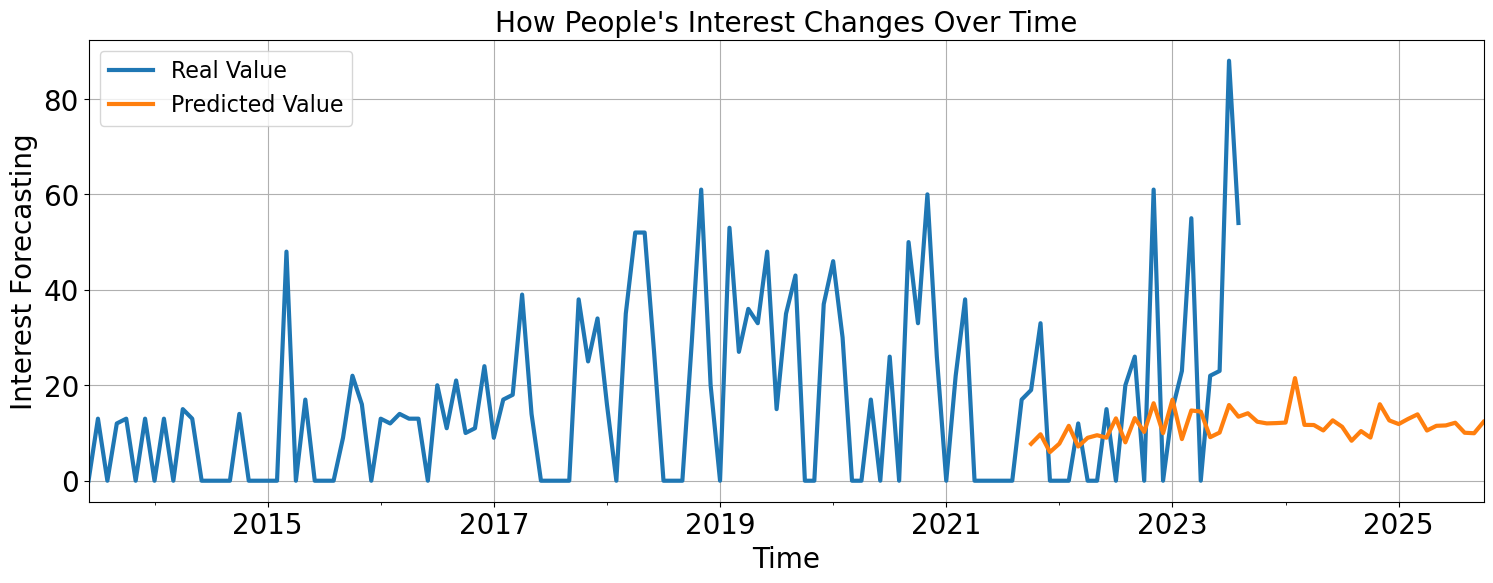

,MAE,MSE,MAPE
Score,17.4595,566.9386,"17,923,982,538,605,968.0000"


In [350]:
model, Score_te = modeling_MLP_slidingwindow1D(df_global, SEQUENCE=SEQUENCE, Y_SCALING=Y_SCALING, MOVING_TYPE=MOVING_TYPE,
                                               TRAIN_WINDOW=TRAIN_WINDOW, FORECASTING_PERIOD=FORECASTING_PERIOD,
                                               HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                                               REGULARIZER=REGULARIZER, DROPOUT_RATIO=DROPOUT_RATIO, MODEL_SUMMARY=MODEL_SUMMARY,
                                               LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS,
                                               VALIDATION_SPLIT=VALIDATION_SPLIT, VALIDATION_DATA=VALIDATION_DATA,
                                               BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                                               MONITOR=MONITOR, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                                               LEARNING_PLOT=LEARNING_PLOT,
                                               PLOT_TITLE=PLOT_TITLE, PLOT_XLABEL=PLOT_XLABEL, PLOT_YLABEL=PLOT_YLABEL)
Score_te

## CNN

Numerical Scaling... ( 2023-09-23 15:18:19.334063 )
X_train: (113, 7, 1) Y_train: (113, 1)
X_test: (8, 7, 1) Y_test: (8, 1)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 7, 128)            384       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 7, 128)           0         
 1D)                                                             
                                                                 
 dropout_43 (Dropout)        (None, 7, 128)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 7, 256)            65792     
                                                                 
 

Training:   0%|                                                                               0/500 ETA: ?s,  …

Epoch 381: early stopping


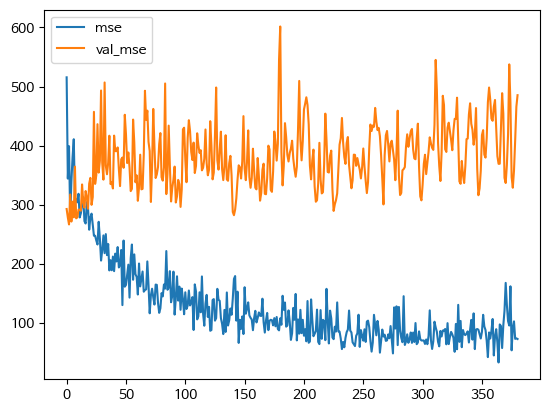

1/1 [==============================] - 0s 11ms/step
Performance: 


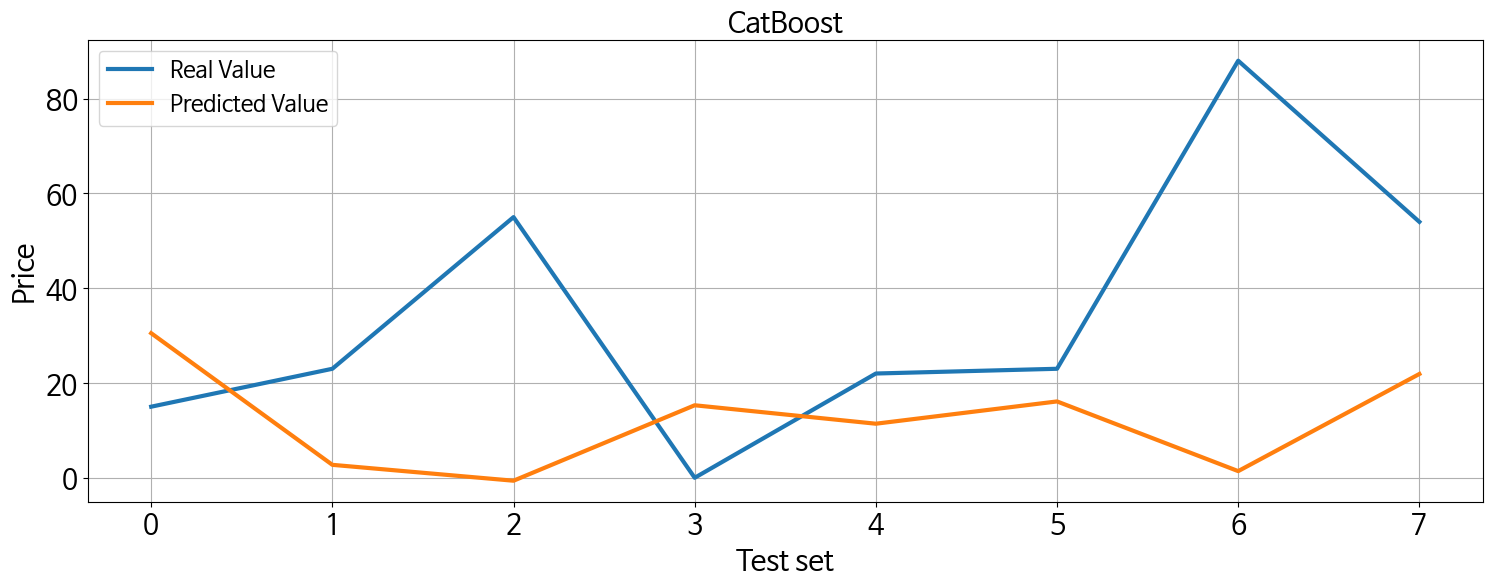

,MAE,MSE,MAPE
Score,30.3585,"1,583.4320","8,612,663,558,930,432.0000"


,MAE,MSE,MAPE
Score,7.6118,209.0223,"11,059,789,602,464,488.0000"


In [16]:
# 전처리
X, Y = reshape_1Dto2Dseq(df_global, SEQUENCE)
X_train, Y_train = X.loc[X.index < test_criteria,:], Y.loc[Y.index < test_criteria,:]
X_test, Y_test = X.loc[X.index >= test_criteria,:], Y.loc[Y.index >= test_criteria,:]
X_train, X_test = feature_num_scaling_trte(preprocessing.MinMaxScaler(), X_train, X_test)
X_train = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test = X_test.values.reshape(-1, X_test.shape[1], 1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# CNN
model = modeling_CNN1D(X_train, Y_train, 
                       HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                       KERNEL_SIZE=KERNEL_SIZE, STRIDE=STRIDE, POOL_SIZE=POOL_SIZE, POOL_STRIDE=POOL_STRIDE,
                       REGULARIZER=REGULARIZER, DROPOUT_RATIO=DROPOUT_RATIO,
                       LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS)
model, save_name = learning(model, X_train, X_test, Y_train,
                            VALIDATION_SPLIT=VALIDATION_SPLIT, VALIDATION_DATA=VALIDATION_DATA,
                            BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                            MONITOR=MONITOR, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                            HISTORY_METRICS=METRICS)
Score_te, Score_trte = prediction_reg(model, X_train, Y_train, X_test, Y_test, ALGO_NAME='CNN1D')
display(Score_te, Score_trte)

## CNN with moving window

  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


  2%|█▋                                                                                 | 1/49 [00:11<09:25, 11.77s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


  4%|███▍                                                                               | 2/49 [00:23<09:09, 11.69s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


  6%|█████                                                                              | 3/49 [00:34<08:54, 11.61s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


  8%|██████▊                                                                            | 4/49 [00:46<08:37, 11.50s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 10%|████████▍                                                                          | 5/49 [00:57<08:20, 11.38s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 12%|██████████▏                                                                        | 6/49 [01:08<08:04, 11.27s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 14%|███████████▊                                                                       | 7/49 [01:19<07:49, 11.17s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 16%|█████████████▌                                                                     | 8/49 [01:30<07:34, 11.09s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 18%|███████████████▏                                                                   | 9/49 [01:41<07:18, 10.95s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 20%|████████████████▋                                                                 | 10/49 [01:51<07:01, 10.81s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 22%|██████████████████▍                                                               | 11/49 [02:01<06:45, 10.67s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 24%|████████████████████                                                              | 12/49 [02:12<06:31, 10.58s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 27%|█████████████████████▊                                                            | 13/49 [02:36<08:49, 14.69s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 29%|███████████████████████▍                                                          | 14/49 [02:55<09:15, 15.88s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 31%|█████████████████████████                                                         | 15/49 [03:04<07:58, 14.08s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 33%|██████████████████████████▊                                                       | 16/49 [03:24<08:38, 15.70s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 35%|████████████████████████████▍                                                     | 17/49 [03:34<07:24, 13.88s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 37%|██████████████████████████████                                                    | 18/49 [03:48<07:12, 13.95s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 39%|███████████████████████████████▊                                                  | 19/49 [03:57<06:16, 12.54s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 41%|█████████████████████████████████▍                                                | 20/49 [04:06<05:33, 11.49s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 43%|███████████████████████████████████▏                                              | 21/49 [04:15<05:03, 10.84s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 45%|████████████████████████████████████▊                                             | 22/49 [04:24<04:35, 10.21s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 47%|██████████████████████████████████████▍                                           | 23/49 [04:33<04:12,  9.70s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 49%|████████████████████████████████████████▏                                         | 24/49 [04:41<03:51,  9.28s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 51%|█████████████████████████████████████████▊                                        | 25/49 [04:49<03:34,  8.94s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 53%|███████████████████████████████████████████▌                                      | 26/49 [04:57<03:20,  8.71s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 55%|█████████████████████████████████████████████▏                                    | 27/49 [05:05<03:05,  8.45s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 57%|██████████████████████████████████████████████▊                                   | 28/49 [05:13<02:52,  8.23s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 52ms/step


 59%|████████████████████████████████████████████████▌                                 | 29/49 [05:21<02:43,  8.15s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 61%|██████████████████████████████████████████████████▏                               | 30/49 [05:28<02:30,  7.91s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 63%|███████████████████████████████████████████████████▉                              | 31/49 [05:35<02:17,  7.65s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [05:51<02:51, 10.11s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [06:05<03:01, 11.32s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [06:19<03:02, 12.18s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [06:33<02:58, 12.75s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [06:47<02:50, 13.12s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 56ms/step


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [07:01<02:39, 13.30s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [07:15<02:27, 13.43s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [07:28<02:14, 13.46s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [07:44<02:07, 14.17s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [07:57<01:50, 13.84s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [08:10<01:35, 13.58s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [08:23<01:20, 13.37s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [08:36<01:05, 13.15s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [08:49<00:52, 13.06s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 55ms/step


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [09:03<00:40, 13.51s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [09:15<00:26, 13.12s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [09:32<00:14, 14.08s/it]

Training:   0%|                                                                               0/500 ETA: ?s,  …

1/1 [==============================] - 0s 54ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [09:44<00:00, 11.92s/it]


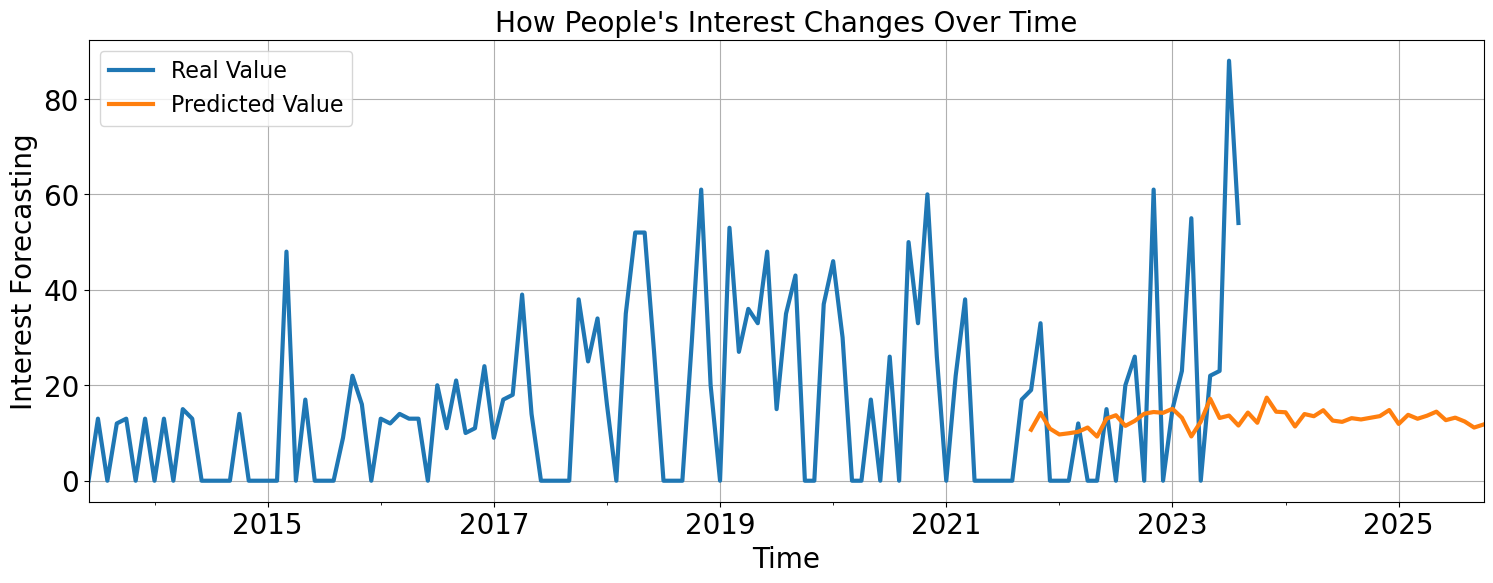

,MAE,MSE,MAPE
Score,17.0343,597.9446,"20,615,308,017,265,084.0000"


In [358]:
model, Score_te = modeling_CNN1D_slidingwindow1D(df_global, SEQUENCE=SEQUENCE, Y_SCALING=Y_SCALING, MOVING_TYPE=MOVING_TYPE,
                                                 TRAIN_WINDOW=TRAIN_WINDOW, FORECASTING_PERIOD=FORECASTING_PERIOD,
                                                 HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                                                 KERNEL_SIZE=KERNEL_SIZE, STRIDE=STRIDE, POOL_SIZE=POOL_SIZE, POOL_STRIDE=POOL_STRIDE,
                                                 REGULARIZER=REGULARIZER, DROPOUT_RATIO=DROPOUT_RATIO, MODEL_SUMMARY=MODEL_SUMMARY,
                                                 LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS,
                                                 VALIDATION_SPLIT=VALIDATION_SPLIT, VALIDATION_DATA=VALIDATION_DATA,
                                                 BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                                                 MONITOR=MONITOR, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                                                 LEARNING_PLOT=LEARNING_PLOT,
                                                 PLOT_TITLE=PLOT_TITLE, PLOT_XLABEL=PLOT_XLABEL, PLOT_YLABEL=PLOT_YLABEL)
Score_te